In [1]:
import math
import pandas as pd
import numpy as np
import seaborn as sns
import networkx as nx
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE, f_regression
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

from sklearn import metrics


# set display option
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# ignore warnings
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import warnings
warnings.simplefilter(action='ignore', category=UserWarning)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

%matplotlib inline
plt.rcParams['font.size'] = 14


# Utility functions

In [2]:
# Regression: Feature selection of the given dataset for model building
def feature_ranking(X, Y, colnames):
    '''
    This function is used to select relevant features for the machine learning model. 
    Feature Selection is the method of reducing the input variable to the model by using 
    only relevant data and getting rid of noise in data. 
    Input:
        X: Predictor variable
        Y: Label/target variable
        colnames: Name of the predictor variable
    
    Output:
        
        meanplot: Mean ranking of the predictor variable for features selection/ranking
    
    '''
    # Define dictionary to store our rankings
    ranks = {}
    # Create our function which stores the feature rankings to the ranks dictionary
    def ranking(ranks, names, order=1):
        minmax = MinMaxScaler()
        ranks = minmax.fit_transform(order*np.array([ranks]).T).T[0]
        ranks = map(lambda x: round(x,2), ranks)
        return dict(zip(names, ranks))

    # Construct Recursive Feature Elimination (RFE) of the Linear Regression model
    lr = LinearRegression()
    lr.fit(X,Y)

    #stop the search when only the last feature is left
    rfe = RFE(lr, n_features_to_select=1, ) #verbose =3
    rfe.fit(X,Y)
    ranks["RFE"] = ranking(list(map(float, rfe.ranking_)), colnames, order=-1)

    # Decision Tree Regressor
    dt = DecisionTreeRegressor()
    dt.fit(X,Y)
    ranks["DT"] = ranking(dt.feature_importances_, colnames)

    # Random Forest Regressor
    rf = RandomForestRegressor(n_jobs=-1, n_estimators=9) #verbose=3
    rf.fit(X,Y)
    ranks["RF"] = ranking(rf.feature_importances_, colnames)

    """ Creating the Feature Ranking Matrix: We combine the scores from the various methods above and output 
    it in a matrix form for convenient viewing as such:"""

    # Create empty dictionary to store the mean value calculated from all the scores
    r = {}
    for name in colnames:
        r[name] = round(np.mean([ranks[method][name] for method in ranks.keys()]), 2)


    methods = sorted(ranks.keys())
    ranks["Mean"] = r
    methods.append("Mean")

    # Put the mean scores into a Pandas dataframe
    meanplot = pd.DataFrame(list(r.items()), columns= ['Feature','Mean Ranking'])

    # Sort the dataframe
    meanplot = meanplot.sort_values('Mean Ranking', ascending=False)
    
    return meanplot



###############################################

# Regression: Feature selection of the given dataset for model building
def feature_ranking_classifier(X, Y, colnames):
    '''
    This function is used to select relevant features for the machine learning model. 
    Feature Selection is the method of reducing the input variable to the model by using 
    only relevant data and getting rid of noise in data. 
    Input:
        X: Predictor variable
        Y: Label/target variable
        colnames: Name of the predictor variable
    
    Output:
        
        meanplot: Mean ranking of the predictor variable for features selection/ranking
    
    '''
    # Define dictionary to store our rankings
    ranks = {}
    # Create our function which stores the feature rankings to the ranks dictionary
    def ranking(ranks, names, order=1):
        minmax = MinMaxScaler()
        ranks = minmax.fit_transform(order*np.array([ranks]).T).T[0]
        ranks = map(lambda x: round(x,2), ranks)
        return dict(zip(names, ranks))

    # Construct Recursive Feature Elimination (RFE) of the Linear Regression model
    lr = LogisticRegression(random_state= 42)  
    lr.fit(X,Y)

    #stop the search when only the last feature is left
    rfe = RFE(lr, n_features_to_select=1, ) #verbose =3
    rfe.fit(X,Y)
    ranks["RFE"] = ranking(list(map(float, rfe.ranking_)), colnames, order=-1)

    # Decision Tree Regressor
    dt = DecisionTreeClassifier()
    dt.fit(X,Y)
    ranks["DT"] = ranking(dt.feature_importances_, colnames)

    # Random Forest Regressor
    rf = RandomForestClassifier(n_jobs=-1, n_estimators=9, ) #verbose=3
    rf.fit(X,Y)
    ranks["RF"] = ranking(rf.feature_importances_, colnames)

    """ Creating the Feature Ranking Matrix: We combine the scores from the various methods above and output 
    it in a matrix form for convenient viewing as such:"""

    # Create empty dictionary to store the mean value calculated from all the scores
    r = {}
    for name in colnames:
        r[name] = round(np.mean([ranks[method][name] for method in ranks.keys()]), 2)


    methods = sorted(ranks.keys())
    ranks["Mean"] = r
    methods.append("Mean")

    # Put the mean scores into a Pandas dataframe
    meanplot = pd.DataFrame(list(r.items()), columns= ['Feature','Mean Ranking'])

    # Sort the dataframe
    meanplot = meanplot.sort_values('Mean Ranking', ascending=False)
    
    return meanplot

# Data understanding and data preparation

This section details the data understanding and preparation of the customer_churn_data dataset. In this section, Created the train and test dataframe from the customer_churn_data dataset for machine learning. 

Performed the data understanding by printing a few rows of the dataframe and checked the missing values and data type etc. of the traffic flow dataset.



In [3]:
# Read the Excel file using Pandas
trainDf = pd.read_excel('customer_churn_data.xlsx')
trainDf

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn(Target)
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes


In [4]:
# check the info
trainDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [5]:
# check the missing values
trainDf.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn(Target)       0
dtype: int64

In [6]:
# check the duplicates
trainDf.drop_duplicates().shape

(7043, 21)

# Exploratory Data Analysis (EDA)
This section discovers the trends and patterns in the dataset and understands the relationship between various variables.

Exploratory Data Analysis (EDA) is an approach we used to analyse the data using visual techniques. EDA is used to check assumptions with the help of statistical summaries and graphical representations. 


In [7]:
print("describe trainDf: \n",trainDf.describe().transpose())


describe trainDf: 
                  count       mean        std    min   25%    50%    75%     max
SeniorCitizen   7043.0   0.162147   0.368612   0.00   0.0   0.00   0.00    1.00
tenure          7043.0  32.371149  24.559481   0.00   9.0  29.00  55.00   72.00
MonthlyCharges  7043.0  64.761692  30.090047  18.25  35.5  70.35  89.85  118.75


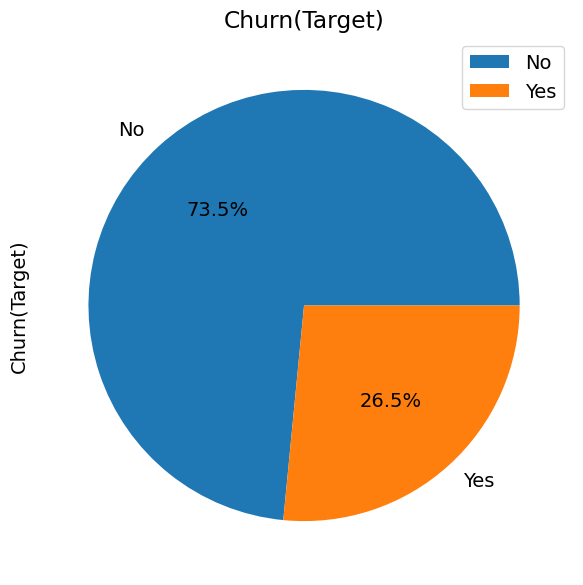

In [8]:
# Hours of the Day (Feature 39) in percentage 
(trainDf.groupby('Churn(Target)')['Churn(Target)'].count()).plot.pie(autopct='%1.1f%%',figsize=(9,7), legend = True)
plt.title("Churn(Target)")
plt.show()

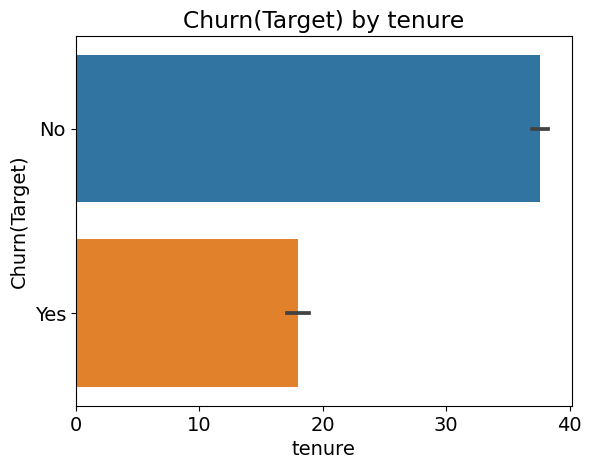

In [9]:
# Replace column names if needed
sns.barplot(x="tenure", y="Churn(Target)", data=trainDf)
plt.title("Churn(Target) by tenure")
plt.xlabel('tenure')
plt.ylabel('Churn(Target)')
plt.show()

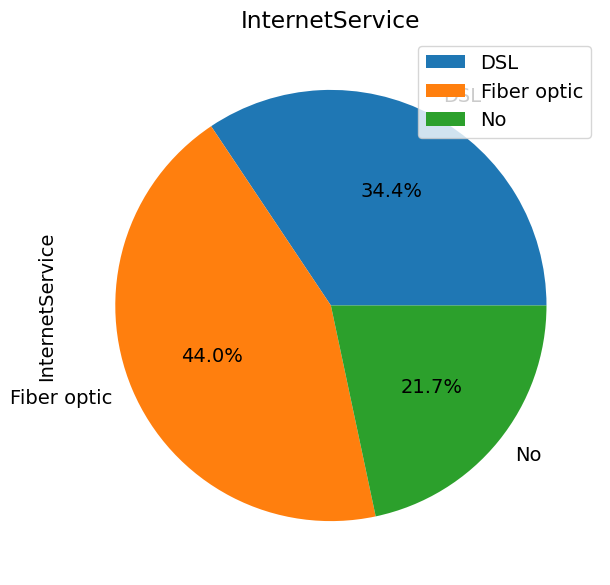

In [10]:
# Hours of the Day (Feature 39) in percentage 
(trainDf.groupby('InternetService')['InternetService'].count()).plot.pie(autopct='%1.1f%%',figsize=(9,7), legend = True)
plt.title("InternetService")
plt.show()

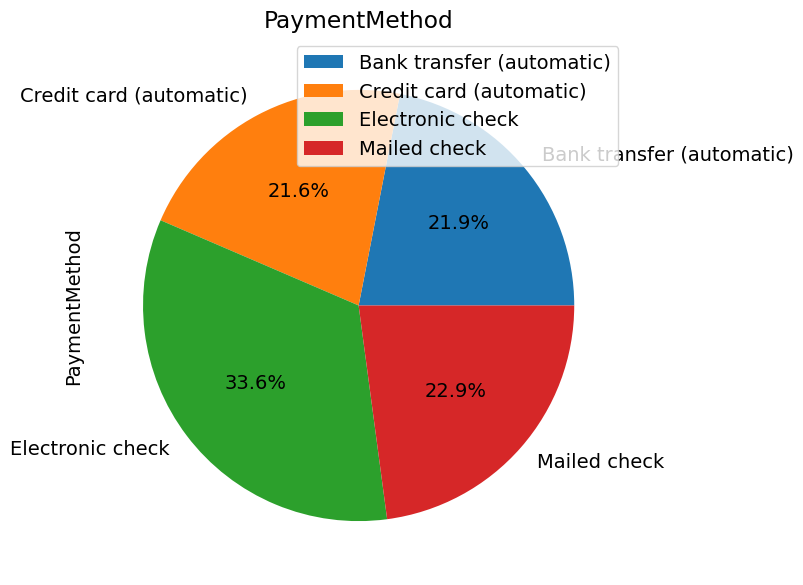

In [11]:
# Hours of the Day (Feature 39) in percentage 
(trainDf.groupby('PaymentMethod')['PaymentMethod'].count()).plot.pie(autopct='%1.1f%%',figsize=(9,7), legend = True)
plt.title("PaymentMethod")
plt.show()

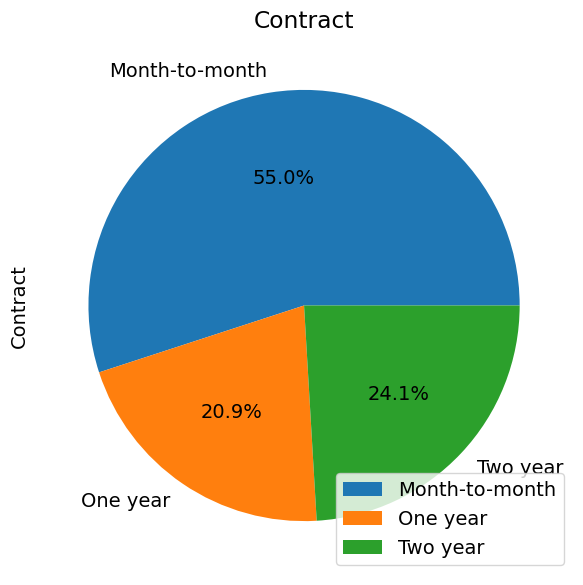

In [12]:
# Contract in percentage 
(trainDf.groupby('Contract')['Contract'].count()).plot.pie(autopct='%1.1f%%',figsize=(9,7), legend = True)
plt.title("Contract")
plt.show()

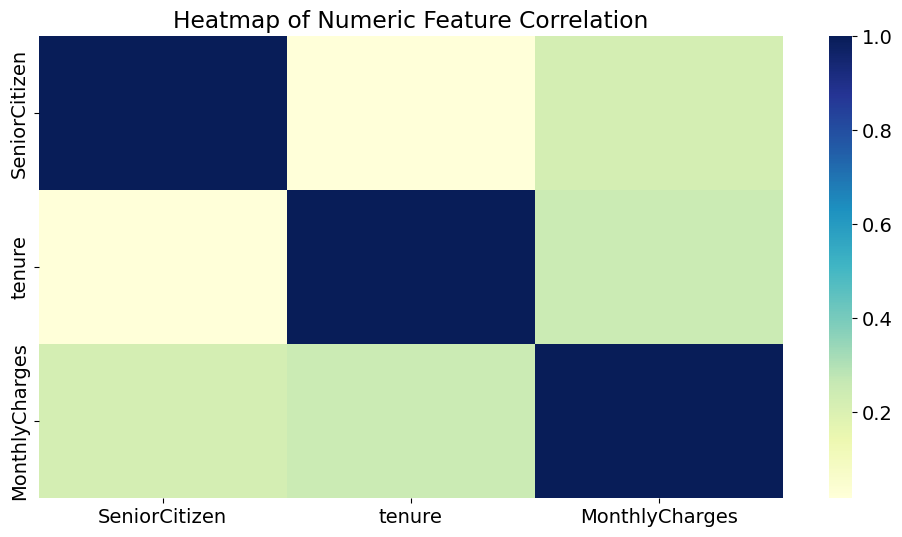

In [13]:
# Heatmap of Traffic Flow
# Select only numeric columns for correlation calculation
numeric_columns = trainDf.select_dtypes(include=[np.number])

# Create a figure and axis
f, ax = plt.subplots(figsize=(12, 6))

# Create a heatmap of the correlation matrix
sns.heatmap(numeric_columns.corr(), cmap="YlGnBu")

# Set the title of the plot
plt.title("Heatmap of Numeric Feature Correlation")

# Display the heatmap
plt.show()

# Classification: Significant Feature Ranking

This section details the importance of features for robust machine learning model building. Feature selection is the method of reducing the input variable to the model by using only relevant data and getting rid of noise in the data.

Build the python function for features ranking name called feature_ranking(). This function is used to select relevant features for the machine learning model. feature_ranking() takes the input as X- Predictor variable, Y - Label/target variable and colnames - Name of the predictor variable. feature_ranking() return the result as the meanplot - mean ranking of the predictor variable for features selection/ranking.

feature_ranking() method can be used as feature selection, variable selection, attribute selection or variable subset selection. In another word, feature selection is the process of selecting a subset of relevant features for use in model construction.

The following plot shows the mean ranking of features of the traffic flow prediction dataset

In [14]:
# label encoding
# Identify columns with mixed data types
mixed_columns = []
for column in trainDf.columns:
    if column != 'CustomerID' and column != 'Churn(Target)':
        mixed_data_types = set(type(value) for value in trainDf[column])
        if len(mixed_data_types) > 1:
            mixed_columns.append(column)

# Convert mixed data type columns to strings
for column in mixed_columns:
    trainDf[column] = trainDf[column].astype(str)

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Loop through each column in the DataFrame
for column in trainDf.columns:
    if column != 'CustomerID' and column != 'Churn(Target)' and trainDf[column].dtype == 'object':
        trainDf[column] = label_encoder.fit_transform(trainDf[column])

trainDf


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn(Target)
0,5375,0,0,1,0,1,0,1,0,0,2,0,0,0,0,0,1,2,29.85,2505,No
1,3962,1,0,0,0,34,1,0,0,2,0,2,0,0,0,1,0,3,56.95,1466,No
2,2564,1,0,0,0,2,1,0,0,2,2,0,0,0,0,0,1,3,53.85,157,Yes
3,5535,1,0,0,0,45,0,1,0,2,0,2,2,0,0,1,0,0,42.30,1400,No
4,6511,0,0,0,0,2,1,0,1,0,0,0,0,0,0,0,1,2,70.70,925,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,4853,1,0,1,1,24,1,2,0,2,0,2,2,2,2,1,1,3,84.80,1597,No
7039,1525,0,0,1,1,72,1,2,1,0,2,2,0,2,2,1,1,1,103.20,5698,No
7040,3367,0,0,1,1,11,0,1,0,2,0,0,0,0,0,0,1,2,29.60,2994,No
7041,5934,1,1,1,0,4,1,2,1,0,0,0,0,0,0,0,1,3,74.40,2660,Yes


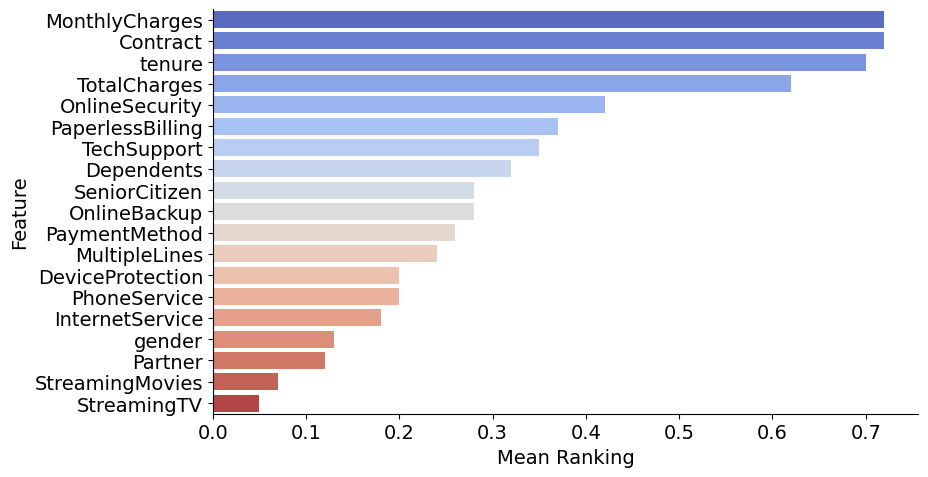

In [15]:
# Extract the input variable and target variable from trainDf
X = trainDf.drop(['customerID','Churn(Target)'],  axis=1)

Y = trainDf[['Churn(Target)']]

# Store the column/feature names into a list "colnames"
colnames = list(X.columns)

# Plot the ranking of the features
meanplot = feature_ranking_classifier(X,Y, colnames)


sns.catplot(x="Mean Ranking", y="Feature", data = meanplot, kind="bar", 
                aspect=1.9, palette='coolwarm')

In [16]:
# sort the mean ranking of the features
meanplot = meanplot.sort_values('Mean Ranking', ascending=False)
meanplot

,Feature,Mean Ranking
17,MonthlyCharges,0.72
14,Contract,0.72
4,tenure,0.70
18,TotalCharges,0.62
8,OnlineSecurity,0.42
15,PaperlessBilling,0.37
11,TechSupport,0.35
3,Dependents,0.32
9,OnlineBackup,0.28
1,SeniorCitizen,0.28


In [17]:
# select the features based on Mean Ranking for model training
columnName = meanplot.loc[meanplot['Mean Ranking']  >= 0.20]
columnName = list(columnName.Feature)
print("No of Feature: ", len(columnName))
print("Columns Name: ", columnName)

No of Feature:  14
Columns Name:  ['MonthlyCharges', 'Contract', 'tenure', 'TotalCharges', 'OnlineSecurity', 'PaperlessBilling', 'TechSupport', 'Dependents', 'OnlineBackup', 'SeniorCitizen', 'PaymentMethod', 'MultipleLines', 'DeviceProtection', 'PhoneService']


# Classification: Choosing machine learning algorithms for model training

Choosing machine learning algorithms for model training is one of the important steps in data mining. The choice of the machine learning algorithms is based on the given problem statement. For this classifier problem statement chosen models are:

1. Logistic Regression
2. Decision Tree Classifier
3. Support Vector Classifier
4. K-Neighbors Classifier
5. RandomForestClassifier
6. Naive Bayes


# Classification: Model training and evaluation

This section details machine learning model building and evaluation of the models. A prepared dataset was used to train and test the ML model performance. Split the training dataset into 70:30 ratios, where 70 portions were used for the model training and 30 portions were used for the model testing.

For model training, tried many permutations and combinations of features selection/ranking and trained and tested the chosen classifier models. Finally, the Mean ranking of the features greater than equal to 0.20 (section 4) is selected for the ML model training.

The performance evaluation report includes the Accuracy, Precision, Recall and f1-Score of the chosen ML models. The ML models performance evaluation report was sorted in descending order.

In [18]:
# Extract the input variable and target variable of the trainDF
X = trainDf[columnName]
y = trainDf[['Churn(Target)']]

# split original data [i.e X and y] into 70:30 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# X_train

In [19]:
# Create the performance report as Accuracy, Precision, Recall and f1-Score of the given models
model_name = []
accuracy_score = []
roc_auc_score = []
precision_score = []
recall_score = []
f1_score = []


def classification_report(ModelName, model_object):
    '''
    This function Create the performance evaluation report as Accuracy, Precision, Recall and f1-Score of the given models
    Input
        ModelName: Name of the ML model
        model_object: Object of the initialized ML model
    Output
        Print Regression report of the given models
    
    '''
    model_object.fit(X_train, y_train)
    y_test_pred = model_object.predict(X_test)
    
    model_name.append(ModelName)
#     print("Model Name:", ModelName)
    
    r2 = round(metrics.accuracy_score(y_test, y_test_pred), 4)
    accuracy_score.append(r2)
#     print("accuracy_score:", r2)
    
    r2 = round(metrics.precision_score(y_test, y_test_pred, average='weighted'), 4)
    precision_score.append(r2)
    # print("precision_score:", r2)
    
    r2 = round(metrics.recall_score(y_test, y_test_pred, average='weighted'), 4)
    recall_score.append(r2)
    # print("recall_score:", r2)    
    
    r2 = round(metrics.f1_score(y_test, y_test_pred, average='weighted'), 4)
    f1_score.append(r2)
    # print("f1_score:", r2)
    

# Train the classifier models
linears = {
    "Logistic Regression": LogisticRegression(), #normalize =True
    "Decision Tree Classifier": DecisionTreeClassifier(),
    "Support Vector Classifier": SVC(),
    "Naive Bayes" : ComplementNB(),
    "K-Neighbors Classifier" : KNeighborsClassifier(),
        }


for key, val in linears.items():
    classification_report(key,val)
    # print('\n')
    
# Train the Random Forest Classifier model
trees = [21,31,51,101]

for tree in trees:
    rf = RandomForestClassifier(n_estimators = tree)
    classification_report("Random Forest Classifier #tree: "+ str(tree), rf)
    # print('\n')

    
evaluation_poly = pd.DataFrame({
                                'Model Name' : model_name,
                                'Accuracy' : accuracy_score,
                                'Precision' : precision_score,
                                'Recall' : recall_score,
                                'f1-Score' : f1_score,
                                })

evaluation_poly.sort_values(['Accuracy'], ascending=False, inplace = True)
print("Performance evaluation report of the models as: \n",  evaluation_poly)

Performance evaluation report of the models as: 
                             Model Name  Accuracy  Precision  Recall  f1-Score
0                  Logistic Regression    0.7984     0.7926  0.7984    0.7948
8  Random Forest Classifier #tree: 101    0.7918     0.7796  0.7918    0.7802
7   Random Forest Classifier #tree: 51    0.7856     0.7729  0.7856    0.7744
5   Random Forest Classifier #tree: 21    0.7828     0.7702  0.7828    0.7723
6   Random Forest Classifier #tree: 31    0.7799     0.7676  0.7799    0.7703
4               K-Neighbors Classifier    0.7549     0.7350  0.7549    0.7379
1             Decision Tree Classifier    0.7430     0.7375  0.7430    0.7399
3                          Naive Bayes    0.7350     0.7810  0.7350    0.7472
2            Support Vector Classifier    0.7283     0.5305  0.7283    0.6139


# Classification: Model selection

The above result shows that the Logistic Regression performs well according to the performance/Classification report as Accuracy, Precision, Recall and f1-Score compared to other models.


# Ensemble ML: Model training and evaluation

This section details machine learning model building and evaluation of the models. A prepared dataset was used to train and test the ML model performance. Split the training dataset into 70:30 ratios, where 70 portions were used for the model training and 30 portions were used for the model testing.

For model training, tried many permutations and combinations of features selection/ranking and trained and tested the chosen classifier models. Finally, the Mean ranking of the features greater than equal to 0.20 is selected for the ML model training.

GridSearchCV technique is used for finding the optimal parameter values from a given set of parameters in a grid. GridSearchCV technique nothing but the essentially a cross-validation technique.

The performance evaluation report includes the Accuracy, Precision, Recall and f1-Score of the chosen ML models. The ML models performance evaluation report was sorted in descending order.

In [20]:
# Extract the input variable and target variable
X = trainDf[columnName]
y = trainDf[['Churn(Target)']]


In [21]:
# Scaling: Since our columns are on different sacle it is important to perform scaling on them, this bring all variable to same range [0,1]

from sklearn import preprocessing
sx = preprocessing.MinMaxScaler()
sy = preprocessing.MinMaxScaler()

scaled_X = sx.fit_transform(trainDf.drop('Churn(Target)',axis='columns'))
# scaled_X

In [22]:
# split original data [i.e X and y] into 70:30 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print("X_train",len(X_train))
print("X_test",len(X_test))
print("y_train",len(y_train))
print("y_test",len(y_test))


X_train 4930
X_test 2113
y_train 4930
y_test 2113


In [23]:
random_state = 42
classifier = [
            DecisionTreeClassifier(random_state = random_state),
            RandomForestClassifier(random_state = random_state),
            LogisticRegression(random_state = random_state),
            SVC(random_state = random_state),
            KNeighborsClassifier(),
            ComplementNB()
            ]


dt_param_grid = {"min_samples_split" : range(10,20),
                "max_depth": range(1,2)}

rf_param_grid = {"max_features": [1,3,10],
                "min_samples_split":[2,3,10],
                "min_samples_leaf":[1,3,10],
                "bootstrap":[False],
                "n_estimators":[11, 21,31,51],
                "criterion":["gini"]}

logreg_param_grid = {"C":np.logspace(-3,3,7),
                    "penalty": ["l2", ]}

svm_param_grid = {"kernel":['poly', 'rbf'],
                  "class_weight": ["balanced"],
                  "decision_function_shape": ['ovo', 'ovr']}

knn_param_grid = {"n_neighbors":[3,5,7],
                  "weights": ["uniform", "distance"],
                  "leaf_size": [20, 30,40,50]}

nb_param_grid = {"norm":[True],
                  "alpha": [0,1],
                  }


classifier_param = [dt_param_grid,
                   rf_param_grid,
                   logreg_param_grid,
                   svm_param_grid,
                   knn_param_grid,
                   nb_param_grid]


In [24]:
cv_result = []
best_estimators = []
for i in range(len(classifier)):
    clf = GridSearchCV(classifier[i], param_grid=classifier_param[i], cv = StratifiedKFold(n_splits = 5), scoring = "accuracy", n_jobs = -1,verbose = 1)
    clf.fit(X_train,y_train)
    cv_result.append(clf.best_score_)
    best_estimators.append(clf.best_estimator_)
    print("best_estimators", best_estimators)
    print("cv_result",cv_result[i])
    print("\n!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!\n")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
best_estimators [DecisionTreeClassifier(max_depth=1, min_samples_split=10, random_state=42)]
cv_result 0.7373225152129818

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

Fitting 5 folds for each of 108 candidates, totalling 540 fits
best_estimators [DecisionTreeClassifier(max_depth=1, min_samples_split=10, random_state=42), RandomForestClassifier(bootstrap=False, max_features=3, min_samples_leaf=10,
                       n_estimators=51, random_state=42)]
cv_result 0.8024340770791076

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

Fitting 5 folds for each of 7 candidates, totalling 35 fits
best_estimators [DecisionTreeClassifier(max_depth=1, min_samples_split=10, random_state=42), RandomForestClassifier(bootstrap=False, max_features=3, min_samples_leaf=10,
                       n_estimators=51, random_state=42), LogisticRegression(C=0.01, random_state=42)]
cv_result 0.7975659229208925

!!!!!!!!!!!!!!!!!!!!!!

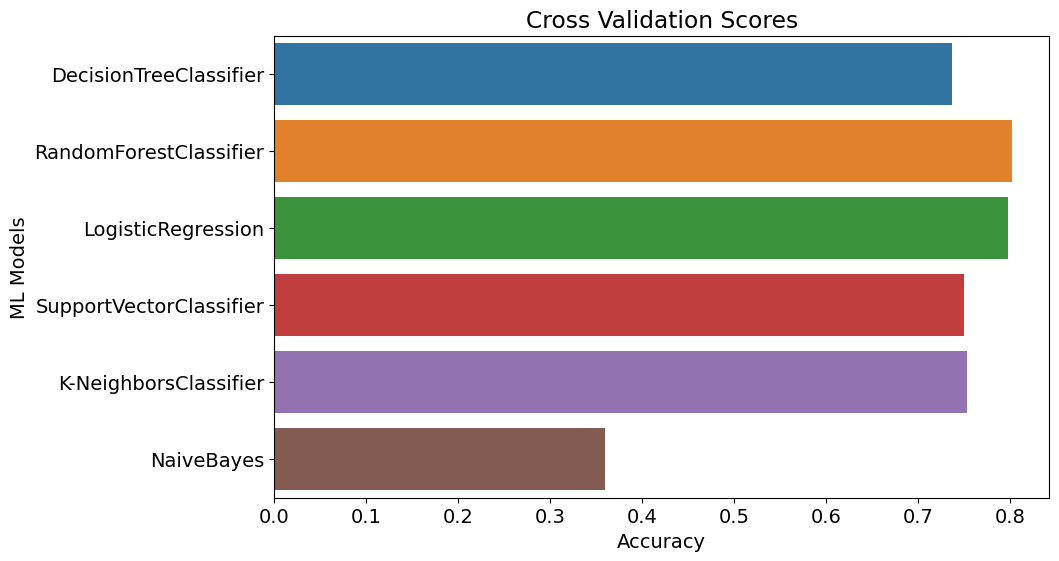

In [25]:
cv_results = pd.DataFrame({"Cross Validation Means":cv_result, "ML Models":["DecisionTreeClassifier", "RandomForestClassifier",
             "LogisticRegression", "SupportVectorClassifier",  "K-NeighborsClassifier", 'NaiveBayes']})


plt.figure(figsize=(10, 6))
g = sns.barplot(x="Cross Validation Means", y="ML Models", data=cv_results)
g.set_xlabel("Accuracy")
g.set_ylabel("ML Models")
g.set_title("Cross Validation Scores")

plt.show()

# Ensemble ML Modeling

In [26]:
votingC = VotingClassifier(estimators = [("dt", best_estimators[1]),
                                        ("rfc", best_estimators[2]),
                                        ("lr", best_estimators[5])],
                                        voting = "soft", n_jobs = -1)
votingC = votingC.fit(X_train, y_train)
print(round(metrics.accuracy_score(votingC.predict(X_test),y_test),4))

0.8079


# Ensemble ML: Model selection

The above result shows that the above models performs well according to the Accuracy performance metrics compared to other ML models.

Tried many permutations and combinations of features selection/ranking and trained and tested the chosen ensemble classifier models. Finally, the ensemble of Random Forest Classifier, Decision Tree and Naive Bayes ML model is selected for further prediction and analytics.